In [1]:
#!/usr/bin/env python3
import logging
import os
import subprocess
import time
 
import matplotlib.pyplot as plt
import numpy as np
from sympy import I
import vmec
from mpi4py import MPI

from simsopt.mhd import Vmec
from neat.fields import StellnaQS, Vmec as Vmec_NEAT
from neat.tracing import ChargedParticle, ParticleOrbit

Trace the orbit of a single particle in a
quasisymmetric stellarator using Near Axis and VMEC   

In [1]:
nfp=4
s_initials = np.round(np.arange(0.5,0.55,0.4), 2) # psi/psi_a for vmec
s_boundaries = np.round(np.arange(1.0,1.1,0.25),2)
theta_initials=np.append(np.round(np.arange(0,2*np.pi/4,2*np.pi/40), 2),\
                         np.round(np.arange(6*np.pi/4,8*np.pi/4,2*np.pi/40), 2)) # initial poloidal angle (vartheta=theta_Boozer - N phi_Boozer)
phi_initials=np.round(np.arange(0.3,2*np.pi/nfp,2*np.pi/nfp/5), 2) # initial toroidal angle (cylindrical on axis)
lambdas=np.round(np.arange(0.8,1.01,0.05), 2) # = mu * B0 / energy

cntr_total=np.zeros((lambdas.size,s_boundaries.size))
cntr_lost_neat=np.zeros_like(cntr_total)
cntr_lost_vmec=np.zeros_like(cntr_total)
cntr_actual_lost=np.zeros_like(cntr_total)
cntr_nan=np.zeros_like(cntr_total)

for j in np.arange(s_boundaries.size):
    
    B0 = 5.3267         # Tesla, magnetic field on-axis (ARIES-CS)
    energy = 3.52e6     # electron-volt
    charge = 2          # times charge of proton
    mass = 4            # times mass of proton     
    vpp_sign = -1       # initial sign of the parallel velocity, +1 or -1
    nsamples = 10000    # resolution in time
    tfinal = 1e-4       # seconds
    constant_b20 =False # use a constant B20 (mean value) or the real function
    
    filename = f"input.nearaxis_sboundary{s_boundaries[j]}"
    wout_filename = f"wout_nearaxis_sboundary{s_boundaries[j]}_000_000000.nc"
    
    Rmajor_ARIES = 7.7495
    Rminor_ARIES = 1.7044

    rminor_factor=2
    r_avg=Rminor_ARIES/rminor_factor
    
    g_field_basis = StellnaQS.from_paper('precise QH', B0=B0, nphi=201)
    g_field = StellnaQS(rc=g_field_basis.rc*Rmajor_ARIES, zs=g_field_basis.zs*Rmajor_ARIES, etabar=g_field_basis.etabar/Rmajor_ARIES, B2c=g_field_basis.B2c*(B0/Rmajor_ARIES/Rmajor_ARIES),\
                        B0=B0, nfp=g_field_basis.nfp, order='r3', nphi=111)
    
    g_field.to_vmec(filename=filename,r=r_avg*np.sqrt(s_boundaries[j]), params={"ntor":7, "mpol":7, "niter_array":[10000,10000,20000]}, ntheta=14, ntorMax=7) #standard ntheta=20, ntorMax=14
    
    if not (os.path.isfile(wout_filename)):
        vmec=Vmec(filename=filename, verbose=True)
        vmec.run()

    g_field_vmec = Vmec_NEAT(wout_filename=wout_filename,maximum_s=0.99)

    for i in np.arange(lambdas.size):
        for s_initial in s_initials:
            for theta_initial in theta_initials:
                for phi_initial in phi_initials:
            
                    g_particle = ChargedParticle(
                        r_initial = r_avg*np.sqrt(s_boundaries[j])*np.sqrt(s_initial),#s=np.sqrt(2*r_initial*psi_a/B0) bc # psi_a=(B0*0.1*0.1)/2
                        theta_initial = theta_initial,
                        phi_initial = phi_initial,    
                        energy = energy,
                        Lambda = lambdas[i],
                        charge = charge,
                        mass = mass,
                        vpp_sign = vpp_sign,
                    )
                    phi_VMEC=g_field.to_RZ([[r_avg*np.sqrt(s_boundaries[j])*np.sqrt(s_initial),theta_initial,phi_initial]])[2][0]
                    g_particle_vmec = ChargedParticle(
                        r_initial = s_initial,
                        theta_initial = np.pi - theta_initial,     
                        phi_initial = phi_VMEC,    
                        energy = energy,
                        Lambda = lambdas[i],
                        charge = charge,
                        mass = mass,
                        vpp_sign = vpp_sign,
                    )
                    g_orbit = ParticleOrbit(
                        g_particle, 
                        g_field, 
                        nsamples = nsamples, 
                        tfinal = tfinal, 
                        constant_b20 = constant_b20
                    )
                    g_orbit_vmec = ParticleOrbit(
                        g_particle_vmec,
                        g_field_vmec,
                        nsamples = nsamples,
                        tfinal = tfinal,
                        constant_b20 = constant_b20,
                    )
                    
                    cntr_total[i][j]+=1
                    if np.any((g_orbit.r_pos/(r_avg*np.sqrt(s_boundaries[j])))**2 > 1):
                        g_orbit_final_time=g_orbit.time[((g_orbit.r_pos/(r_avg*np.sqrt(s_boundaries[j])))**2 > 1)][0]
                        g_orbit_time=g_orbit.time[(g_orbit.time < g_orbit_final_time)]
                        print(g_orbit_final_time)
                        cntr_lost_neat[i][j]+=1
                        print('NEAT - Lost particle')
                    else:
                        g_orbit_time=g_orbit.time

                    if (g_orbit_vmec.time[-1]!=tfinal) or (g_orbit_vmec.r_pos[-1]==np.nan):
                        cntr_lost_vmec[i][j]+=1 
                        if (g_orbit_vmec.time[-1]!=tfinal): cntr_actual_lost[i][j]+=1
                        if (g_orbit_vmec.r_pos[-1]==np.nan): cntr_nan[i][j]+=1
                    
                    #Calculating differences between near axis and vmec
                    
                    diff_r = (g_orbit.rpos_cylindrical[0][:g_orbit_vmec.rpos_cylindrical[0].shape[0]] - g_orbit_vmec.rpos_cylindrical[0][:g_orbit.rpos_cylindrical[0].shape[0]]
                        ) / g_orbit_vmec.rpos_cylindrical[0][:g_orbit.rpos_cylindrical[0].shape[0]]

                    avg_Z_vmec=np.sum(np.abs(g_orbit_vmec.rpos_cylindrical[1][:g_orbit.rpos_cylindrical[0].shape[0]]))/g_orbit.rpos_cylindrical[0].shape[0]
                    max_Z_vmec=np.max(np.abs(g_orbit_vmec.rpos_cylindrical[1][:g_orbit.rpos_cylindrical[0].shape[0]]))
                    diff_Z = (g_orbit.rpos_cylindrical[1][:g_orbit_vmec.rpos_cylindrical[0].shape[0]] - g_orbit_vmec.rpos_cylindrical[1][:g_orbit.rpos_cylindrical[0].shape[0]])/max_Z_vmec
                    diff_phi= (np.unwrap(np.mod(g_orbit.rpos_cylindrical[2][:g_orbit_vmec.rpos_cylindrical[0].shape[0]], 2*np.pi)) - np.unwrap(np.mod(g_orbit_vmec.rpos_cylindrical[2][:g_orbit.rpos_cylindrical[0].shape[0]], 2*np.pi))
                    ) / (2 * np.pi)

                    _ = plt.figure(figsize=(25, 12))
                    plt.subplot(3, 4, 1)
                    plt.plot(g_orbit_time*1e6, g_orbit.rpos_cylindrical[0][:g_orbit_time.size], label='Particle 1')
                    plt.xlabel(r't ($\mu$s)')
                    plt.ylabel(r'$R$')
                    plt.subplot(3, 4, 2)
                    plt.plot(g_orbit_time*1e6, g_orbit.rpos_cylindrical[1][:g_orbit_time.size], label='Particle 1')
                    plt.xlabel(r't  ($\mu$s)')
                    plt.ylabel(r'$Z$')
                    plt.subplot(3, 4, 3)
                    plt.plot(g_orbit_time*1e6, np.mod(g_orbit.rpos_cylindrical[2][:g_orbit_time.size], 2*np.pi), label='Particle 1')
                    plt.xlabel(r't  ($\mu$s)')
                    plt.ylabel(r'$\Phi$')
                    plt.subplot(3, 4, 4)
                    plt.plot(g_orbit.rpos_cylindrical[0][:g_orbit_time.size], g_orbit.rpos_cylindrical[1][:g_orbit_time.size], label='Particle 1')
                    plt.xlabel(r'$R$')
                    plt.ylabel(r'$Z$')
                    plt.subplot(3, 4, 5)
                    plt.plot(g_orbit_vmec.time*1e6, g_orbit_vmec.rpos_cylindrical[0], label='Particle 1')
                    plt.xlabel(r't ($\mu$s)')
                    plt.ylabel(r'$R_V$')
                    plt.subplot(3, 4, 6)
                    plt.plot(g_orbit_vmec.time*1e6, g_orbit_vmec.rpos_cylindrical[1], label='Particle 1')
                    plt.xlabel(r't  ($\mu$s)')
                    plt.ylabel(r'$Z_V$')
                    plt.subplot(3, 4, 7)
                    plt.plot(g_orbit_vmec.time*1e6, np.mod(g_orbit_vmec.rpos_cylindrical[2], 2*np.pi), label='Particle 1')
                    plt.xlabel(r't  ($\mu$s)')
                    plt.ylabel(r'$\Phi_V $')
                    plt.subplot(3, 4, 8)
                    plt.plot(g_orbit_vmec.rpos_cylindrical[0], g_orbit_vmec.rpos_cylindrical[1], label='Particle 1')
                    plt.xlabel(r'$R_V$')
                    plt.ylabel(r'$Z_V$')
                    plt.subplot(3, 4, 9)
                    plt.plot(g_orbit_vmec.time*1e6, np.abs(diff_r)*100, label='Particle 1')
                    plt.xlabel(r't ($\mu$s)')
                    plt.ylabel(r'$\Delta  R (\%)$')
                    plt.subplot(3, 4, 10)
                    plt.plot(g_orbit_vmec.time*1e6, np.abs(diff_Z)*100, label='Particle 1')
                    plt.xlabel(r't  ($\mu$s)')
                    plt.ylabel(r'$\Delta  Z (\% of max)$')
                    plt.subplot(3, 4, 11)
                    plt.plot(g_orbit_vmec.time*1e6, np.abs(diff_phi), label='Particle 1')
                    plt.xlabel(r't  ($\mu$s)')
                    plt.ylabel(r'$\Delta \Phi (turns)$')
                    #plt.subplot(3, 4, 12)
                    #plt.plot(diff_r,diff_Z, label='Particle 1')
                    #plt.xlabel(r'$\Delta R$')
                    #plt.ylabel(r'$\Delta Z$')
                    plt.legend()
                    if not os.path.exists('s_b=' + str(s_boundaries[j])):
                        os.mkdir('s_b=' + str(s_boundaries[j]))
                    plt.savefig('s_b=' + str(s_boundaries[j]) + '/s_b=' + str(s_boundaries[j]) + '_lambda=' + str(lambdas[i]) + '_s_i=' + str(s_initial) + \
                        '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '.png')
                    g_orbit_vmec.plot(show=False, savefig='s_b=' + str(s_boundaries[j]) + '/s_b=' + str(s_boundaries[j]) + '_lambda=' + str(lambdas[i]) + '_s_i=' + str(s_initial) + \
                        '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_vmec_parameters.png')
                    print(s_boundaries[j],lambdas[i],s_initial,theta_initial,phi_initial)
                    g_orbit.plot(show=False, savefig='s_b=' + str(s_boundaries[j]) + '/s_b=' + str(s_boundaries[j]) + '_lambda=' + str(lambdas[i]) + '_s_i=' + str(s_initial) + \
                        '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_neat_parameters.png')
                    g_orbit.plot_orbit_3d(show=False, r_surface=r_avg*np.sqrt(s_boundaries[j]), savefig='s_b=' + str(s_boundaries[j]) + '/s_b=' + str(s_boundaries[j]) + '_lambda=' + str(lambdas[i]) + '_s_i=' + str(s_initial) + \
                        '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_neat_orbit.png')
                    g_orbit_vmec.plot_orbit_3d(show=False,savefig='s_b=' + str(s_boundaries[j]) + '/s_b=' + str(s_boundaries[j]) + '_lambda=' + str(lambdas[i]) + '_s_i=' + str(s_initial) + \
                        '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_vmec_orbit.png')
                    plt.show()
        

NameError: name 'np' is not defined

In [2]:
print(cntr_total)
print(cntr_lost_neat)
print(cntr_lost_vmec)
print(cntr_actual_lost)
print(cntr_nan)

NameError: name 'cntr_total' is not defined

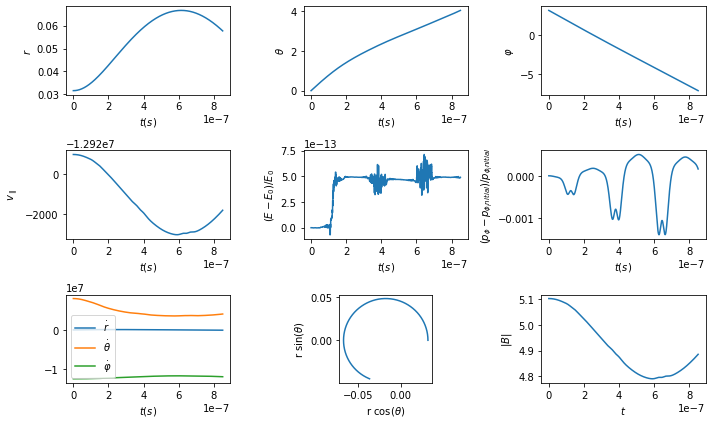

In [ ]:
#Creating parameter plot for NA
g_orbit.plot(show=True)

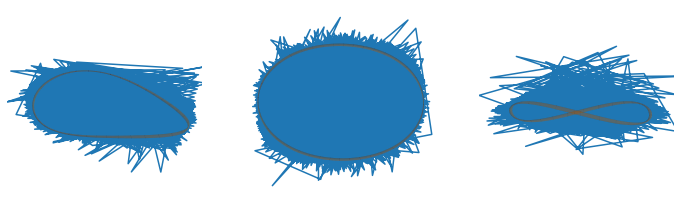

In [ ]:
#Creating 3D plot for NA
g_orbit.plot_orbit_3d(show=False)

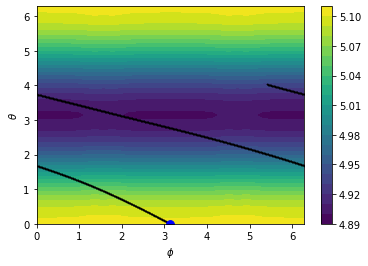

In [ ]:
#Creating B contour plot for NA
g_orbit.plot_orbit_contourB(show=False)

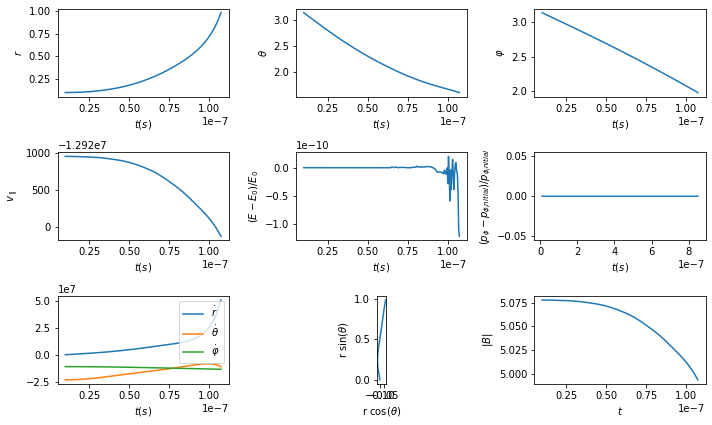

In [ ]:
#Creating parameter plot for VMEC
g_orbit_vmec.plot(show=True)

In [ ]:
# print("Creating 2D plot")
# g_orbit.plot_orbit(show=False)

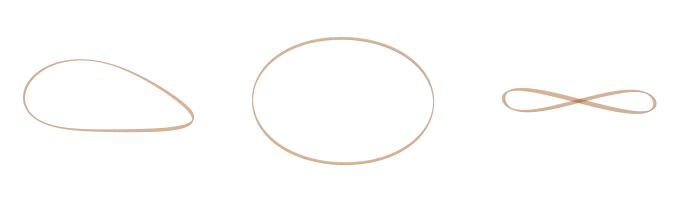

In [ ]:
#Creating 3D plot for VMEC
g_orbit_vmec.plot_orbit_3d(show=False)

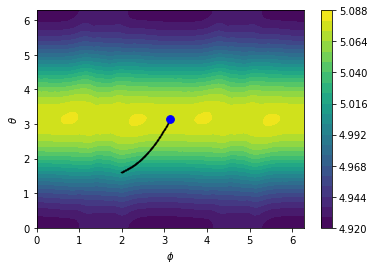

In [ ]:
#Creating B contour plot for VMEC
g_orbit_vmec.plot_orbit_contourB(show=False)

In [ ]:
print(g_field.etabar)
print(g_field.r1_diagnostics)